# A crash course on parameter estimation of computational models using a Bayesian optimization approach

## Introduction

Parameter estimation is an inevitable aspect of computational modeling projects, especially the ones that deal with partial differential equation (PDE) models. Well-known examples in this regard are the PDE models that come from a basic balance or conservation law, such as mass balance or heat transfer problems. For real-world applications, these PDEs contain some coefficients that cannot be obtained directly from published scientific materials or experimental studies. A good solution to this problem is constructing an inverse problem.

Take a simple reaction-diffusion equation as an example, in which the change of concentration of sample chemical component $C$ is studied over time. By assuming that the correlated chemical reaction is $ A + 2B \rightleftharpoons C$, occurring in a diffusible medium (such as a chemical solution), the PDE to describe the mass transfer phenomenon over time can be written as:

$$ \frac{\partial [C]}{\partial t} = \nabla . \left( D_C \nabla [C] \right) + k_1 [A][B]^2 - k_2 [C] $$

in which $[X]$ denotes the concentration of the chemical component $X$, the $ D_C $ is the diffusion coefficient of C in the medium, and $k_1$ and $k_2$ are the rates of the forward and backward reactions respectively. To solve this PDE numerically and get quantitative data (which is the goal of most of the scientific computing projects), we need to know the value of the $ D_C $, $k_1$, and $k_2$. The diffusion coefficient of different materials can be found in the literature (although it does not necessarily mean that the value is suitable for any problem because diffusion might be affected by chemical processes and presence of other materials), but the reaction rates are rarely known for a wide variety of chemical reactions. As a result, the computational model that simulates this equation cannot produce quantitative output. 

As mentioned above, one solution is making an inverse problem out of this challenge. An inverse problem in science is the process of calculating from a set of observations the causal factors that produced them. Inverse problems are some of the most important mathematical problems in science and mathematics because they tell us about parameters that we cannot directly observe. That's exactly what we want to do: estimating parameters that cannot be directly measured for our computational model, which is called parameter estimation or model calibration. Indeed, we calibrate our model to act similarly to available experimental data, and then this calibrated model can be used to simulate other scenarios that are not tested in experiments. This concept is so similar to the training process of machine learning models, in which you train the model by making it fit to previously available data and ask it to predict unseen data.

To construct an inverse problem for computational models, we can take advantage of conventional optimization approaches, in which the goal is to minimize or maximize a function, or more technically speaking, an objective function. Mathematical optimization is the selection of a best element (with regard to some criterion) from some set of available alternatives.  In the simplest case, an optimization problem consists of maximizing or minimizing a real function by systematically choosing input values from within an allowed set and computing the value of the function. More generally, optimization includes finding the best available values of some objective function given a defined domain (or input), including a variety of different types of objective functions and different types of domains. To wrap up, the important concepts here are the objective function (what we want to minimize) and the domain space (values of the parameters over which we minimize the objective).

To map this definition to our problem, our objective function will be the difference between the produced output of our simulation and the experimental data of the exact condition, which is also called "loss". In other words, we change the coefficients in a way that the simulation output would be the same as (or close to) the experimental data that we already have. To this end, we can simply choose random values or a previously-built uniform grid of input values out of the domain space (the range that we search for appropriate values), evaluate the model with those values, and continue this process till we found the lowest loss possible. As long as the evaluation of the cost function is cheap, which for our case means the simulations run fast (because we need to run the simulation to evaluate the cost function), this can be a good approach. The problem is, for most of the time-dependent PDE-based computational models (especially in 3D), running each simulation takes quite long, and as a result, each iteration of the optimization algorithm is not cheap anymore. It is also worth mentioning that taking advantage of the reliability of gradient-based optimization techniques is not applicable for this problem because we cannot calculate the gradient (Jacobian) of the cost function as it is determined by running an external simulation.  

## Bayesian optimization

To describe how the Bayesian optimization approach helps us to overcome the aforementioned problem, I use the great description made by @WillKoehrsen. I can't describe it better (the full interactive document can be found [here](https://github.com/WillKoehrsen/hyperparameter-optimization/blob/master/Introduction%20to%20Bayesian%20Optimization%20with%20Hyperopt.ipynb)):

"
Evaluating the objective function is the expensive part of optimization, so ideally we want to limit calls to this function. One way we can limit calls is by choosing the next values to try in the objective function based on the past results. Bayesian optimization differs from random or grid search by doing exactly this: rather than just selecting from a grid uninformed by past objective function evaluations, Bayesian methods take into account the previous results to try more promising values. They work by constructing a probability model of the objective function (called a surrogate function) $p(\text{score} | \text{parameters}$ which is much easier to optimize than the actual objective function.

After each evaluation of the objective function, the algorithm updates the probability model (usually given as $p(y | x)$ incorporating the new results. [Sequential Model-Based Optimization (SMBO) methods are a formalization of Bayesian optimization](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f) that updates the probability model sequentially: every evaluation of the objective function with a set of values updates the model with the idea that eventually the model will come to represent the true objective function. This is an application of Bayesian Reasoning. The algorithm forms an initial idea of the objective function and updates it with each new piece of evidence.

The next values to try in the objective function are selected by the algorithm optimizing the probability model (surrogate function) usually with a criterion known as Expected Improvement. Finding the values that will yield the greatest expected improvement in the surrogate function is much cheaper than evaluating the objective function itself. By choosing the next values based on a model rather than randomly, we hope that the algorithm would converge to the true best values much quicker. The overall goal is to evaluate the objective function fewer times by spending a little more time choosing the next values. Overall, Bayesian Optimization and SMBO methods:

* Converge to a lower score of the objective function than random search
* Require far less time to find the optimum of the objective function

So, we get both a faster optimization and a better result. These are both two desirable outcomes especially when we are working with heavy computational models!
"

According to this simplified description, Bayesian optimization is a great candidate to perform the parameter estimation of PDE-based computational models. Beside this, if you want to know more about the mathematical aspects of the Bayesian optimization, you may have a look at [this short guide](https://app.sigopt.com/static/pdf/SigOpt_Bayesian_Optimization_Primer.pdf). 

In this notebook, we implement the whole process of doing that, including constructing a cost function by calling the simulation code, performing the optimization, and post-processing the results. To do this, we use Python and HyperOpt, an open-source Python library for Bayesian optimization that implements SMBO using the Tree-structured Parzen Estimator (TPE). TPE, along with Gaussian Processes and Random Forest Regression, are the algorithms that can be used in the SMBO method to construct the probability model (surrogate function). We don't need to worry about implementing the algorithm because Hyperopt takes care of that for us. We just have to make sure we have properly defined the objective function and the domain of values to search over.

## Sample problem

### Fitting a 4th-order polynomial equation 

Instead of a PDE model, we use a simpler problem to focus more on the optimization rather than the numerical simulation of the PDE. The problem with which the optimization algorithm interact is a fitting a 4th-order polynomial equation on some experimental data. You should pay notice that the optimization algorithm is completely unaware of the fitting problem behind the objective function. 

The objective function is implemented in a general way: calling the external simulation code, gathering produced output, and computing the loss. To make this as real-world as possible, I implemented an external Python code that takes polynomial coefficients and computes the function values on desired points. This data is saved on the disk and then retrieved by the objective function of the main optimization code to calculate the loss. In a real-world application, the external simulation code takes the coefficients (such as the reaction rates in the above PDE example), performs the simulation, and writes the output to the disk. The rest of the process is the same. In the next step, the optimization algorithms changes the parameters and calls the external simulation code again to see the loss of the new parameters. This process continues iteratively to a certain number of iterations.

The experimental data, which are indeed 21 points of a 4th-order polynomial function in the range $[0, 5]$, are stored in a csv file. Each line contains one point, better to say a pair of two values defining a point, and this exactly what it can be in a real scenario. For example, it can contain the value of a chemical component concentration over time, in which the first and second values of each line would be time and concentration, respectively. The stored data can be plotted using Matplotlib library.  

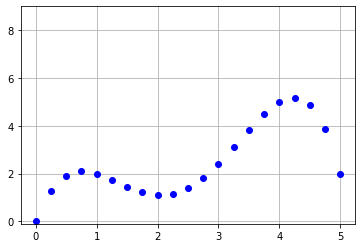

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

x = []
y = []
with open("data.csv", 'r') as f:
    lines = f.readlines()
    for item in lines:
        x.append(float(item.split(',')[0]))
        y.append(float(item.split(',')[1]))

plt.plot(x, y, 'bo')
plt.ylim(-0.1, 9)
plt.grid(True)
plt.show()

The general 4th-order polynomial equation is:

$$ f(x) = c_4 x^4 + c_4 x^3 + c_2 x^2 + c_1 x + c_0 $$

As it should be clear till now, the whole story is to find the coefficients $[c_0 ... c_4]$. From the data, we already know that the equation should pass through the origin $ (0, 0) $, so it can be simplified to:  

$$ f(x) = c_4 x^4 + c_4 x^3 + c_2 x^2 + c_1 x $$

results to 4 unknown parameters instead of 5. The goal of the optimization algorithm is to find these four parameters. Before going through the steps that should be taken to do this, let's first have a look at the correct values of these parameters. The correct values are:

$$ c_4 = -0.25, c_3 = 2.35, c_2 = -6.75, c_1 = 6.65 $$

We can check these coefficients simply by using the `poly1d` function of the Numpy package.


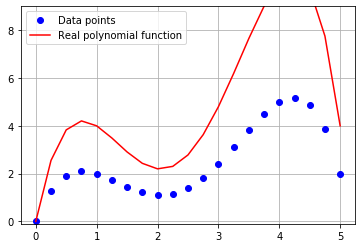

In [2]:
import numpy as np

f = np.poly1d([-0.25, 2.35, -6.75, 6.65, 0])

plt.plot(x, y, 'bo', label="Data points")
plt.plot(x, f(x)*2, '-r', label="Real polynomial function")
plt.ylim(-0.1, 9)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Please pay attention that we don't use this knowledge at all, and instead, we will use the Bayesian optimization algorithm to find these values. It is also worth noting that this problem is a lit bit more complex than the parameter estimation of common PDE-based simulations. The reason is, for PDE-models, changing constant coefficients, such as reaction rates in the aforementioned reaction-diffusion equation, does not change the behavior of the system dramatically. Put differently, most of the time, the output of the simulation is qualitatively similar to the experimental data, and we need to calibrate the model using the specific search domains about which we already have some clue. In contrast, in the problem that we have here, changing the coefficients, especially the multiplier of the high order terms, has a great impact on the behavior of the polynomial function. I said this to assert that this problem is complex enough to be looked as a case with 4 unknown parameters.

### Simulating an external simulation program

As mentioned above, to make the optimization like a real scientific computing scenario, an external python code is implemented to perform the calculation of the 4th-order polynomial outside of the main optimization code. In each iteration of the optimization, the objective function code calls this external program, waits for it to complete its computation, and gathers its results. These results are then used to compute the loss of each iteration by comparing them to the experimental data.

There are several ways to communicate with external simulation codes, such as writing the parameters to the disk and ask the simulation code to read it or manipulating the input file of the simulation directly. If the simulation program is an in-house code developed by yourself and doesn't need any specific input file to work, the simplest method for passing the parameters will be the command line arguments. Although it doesn't seem so, making it happen in this way is really simple. In fact, all you need to do is to pass the parameters during the process of calling the program, and then by having a few lines of code, they can be retrieved in the simulation code. For example, the command to call the program can be something like `python external.py arg1 arg2 arg3`, in which the arg1, arg2, and arg3 are the command line arguments.

If it still looks complicated, have a look at our external simulation program code, which is stored as external.py. The program reads the passed parameters and constructs a polynomial function. Then it evaluates the constructed function on the range $(0, 5$ (which should be the same range as our experimental data) and stores the result to the disk. The file name pattern of the output is "result-{Run Number}.txt", in which the "Run Number" is the iteration number of the main optimization code that has been passed by the arguments as well. The passed parameters are also saved in the first line of the output to make the post-processing much easier. It is a good practice in this regard because it helps us to know which parameters have caused the output by looking at the file.

The external.py program is:

```python
import sys
import numpy as np

# we expect 6 arguments (the first arg is always the program name)
# the next one is the run number, which is used to name the output files
# the last four args are the passed coefficients of the polynomial
if len(sys.argv) != 6:
    print("Not enough input parameters!")
    quit()

runNumber = sys.argv[1] # used to create the output filename
coefs = [float(arg) for arg in sys.argv[2:6]] # convert args from string to float
coefs.append(0) # we already know that the function pass through (0, 0)

func = np.poly1d(coefs) # create the main polynomial function using the passed args

x = np.linspace(0, 5, 21)
y = func(x) # evaluate the function on the range (0, 5)

f = open("output/result-{0}.txt".format(runNumber), 'w+')

# we write the passed four coefficients to the first line of the output
# it helps us to know which parameters have caused this output
firstLine = "".join([str(item) + " " for item in coefs])
f.write(firstLine + "\n")

# write each point in a separate line
for i in range(len(x)):
    f.write("{0} {1}\n".format(x[i], y[i]))

```

## Optimization procedure

### Implementation

Now everything is ready to dive into the optimization code. The first step, like any other Python project, is importing required packages. Here we need two sets of packages: the ones that are required for the optimization process, and the ones we will use to post-process the results and see the performance of the optimization process. The main package in the first set is HyperOpt, and as described above, it can be used to perform Bayesian optimization in Python projects. The two important packages in the second set are Pandas and Seaborn, which are popular Python data processing packages, and here, we will use them to process the data produced by the optimization algorithm.

In [3]:
# packages required for optimization
import numpy as np
from hyperopt import hp, tpe, fmin, Trials
import os
import time

# packages required for post-processing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

The experimental data (here called targets allover the code) are stored separately in a CSV file. Each line of this CSV file contains a pair of values, in which the first value is the time (or X-axis of the data), and the second one is the value of the variable of interest (or Y-axis of the data). We store these values in two separate lists.   

In [4]:
targetValues = [] # target values. will be read from a CSV file
timeValues   = [] # time of the target values. will be read from a CSV file

Now it's the time to define some basic helper functions. The first function we need is a piece of code to denormalize values from the range of $[0, 1]$ to a desired range. Why do we need this? The reason is normalizing values prior to performing optimization is usually highly recommended, and we do that as well. So the domain on which we perform a search to find proper value in this code is always $[0, 1]$, but the actual rate is something else (you will see how to define it shortly ahead). To put it in other words, the optimization algorithm sees the domain space of $[0, 1]$ for all the parameters, but in the end, we want to see the optimum values (that minimizes the cost function) in their real range, so we need to denormalize the values. This function does that.    

In [5]:
def denormalize(name, value):
    """
    Denormalizes input from [0 1] based on the real range defined

    Parameters
    ----------
    name : string
        The name of the variable. should match the name in 'ranges'
    value : float
        The value to be denormalized

    Returns
    -------
    output : float
        Denormalized value
    """
    return value * (ranges[name][1] - ranges[name][0]) + ranges[name][0]

Before optimization, we read the target values (described above) from the CSV file and store them in appropriate containers (Python lists).

In [6]:
def readTargets():
    """
    Reads target values to be used in evaluating error of each optimization step.
    data should be in a csv file, two values per line: [time value]. this scheme
    can be modified easily.
    timeValues: The list of first elements of each pair in each line of the csv file
    targetValues: The list of second elements of each pair in each line of the csv file
    """
    timeValues.clear()
    targetValues.clear()
    
    with open("data.csv", 'r') as f:
        lines = f.readlines()
        for item in lines:
            timeValues.append(float(item.split(',')[0]))
            targetValues.append(float(item.split(',')[1]))

RMSE is the abbreviation of Root Mean Square Error and shows the difference (error) between two sets of data. According to [Wikipedia](https://en.wikipedia.org/wiki/Root-mean-square_deviation), "root-mean-square error (or sometimes root-mean-squared error) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed". In fact, what we minimize by the Bayesian optimization algorithm is the RMSE of predicted values of the model (external simulation program) and the experimental data (stored in the CSV file). This function computes RMSE of two sets, predictions and targets, by taking advantage of super simple Numpy vector analysis operations.

In [7]:
def rmse(predictions, targets):
    """
    Computes Root-Mean-Square Error of simulation output and target values.
    the input lists should have the same size.

    Parameters
    ----------
    predictions : list
        Simulation output values
    target : list
        Targets values obtained from external source file

    Returns
    -------
    output : float
        RMS error of two lists
    """
    return np.sqrt(((predictions - targets) ** 2).mean())

As the name of the following function suggests, it is the main function of the optimization process we want to perform: the objective function. HyperOpt calls this function in each iteration with a new set of input values (guessed values) and tries to minimize it, which is indeed minimizing the RMS error. It first calls a function to call the external simulation program with the passed (guessed) input parameters, and then, calculate the error with the help of `rmse` function.

In [8]:
def objective(input):
    """
    Main objective function, constructed based on the RMS error between simulated values
    and target values. It first calls the simulation and then computes the
    error based on the generated output. This error is used to choose the next suggest of
    the design parameters.

    Parameters
    ----------
    input : dictionary
        Current value of design paramters, determined by the bayesian algorithm

    Returns
    -------
    output : float
        RMS error of current evaluation of objective function
    """
    # names should match the names defined in 'space' variable
    output = callExternal(input['c4'], input['c3'], input['c2'], input['c1'])
    return rmse(np.array(output), np.array(targetValues))

The `callExternal` function is responsible to call the external simulation program, collect the output, and pass it back to the objective function that has called it. This function should work in sync with the external simulation in a way that no error occurs. In each iteration of the optimization process, this function will be called once, so keeping track of the current iteration number can be done just by having a counter (`iterNumber` here) that increases in each function call. This iteration number is also passed to the simulation program to name the output file. This makes it easy to post-process the results of the optimization because we then know to which iteration number the result file belongs. This function also stores the run time of each simulation calls in a text file (`time.txt`), and although this file will not be used in post-processing and further steps, it can act as valuable debug information after the optimization is done.

In [9]:
iterNumber = 0 # used to hold current optimization step in order to name output file

def callExternal(c4, c3, c2, c1):
    """
    Calls the main simulation based on the input values and returns a list of
    simulation output. The list used to calculate the error of the objective
    function. In addition, this function records the runtime duration of
    each simulation into a text file (time.txt).

    Parameters
    ----------
    All the parameters we want to estimate. Here as an example, we have four parameters
    passed to the finite element code.

    Returns
    -------
    output : list
        A list containing all the output points of the performed simulation
    """
    global iterNumber
    # the parameters are normalized. we should denormalized them first
    # any additional preprocessing can be performed here
    c4 = denormalize('c4', c4)
    c3 = denormalize('c3', c3)
    c2 = denormalize('c2', c2)
    c1 = denormalize('c1', c1)
    iterNumber += 1
    start = time.time()
    # here is the main call to the external simulation. it can be any internal or external code,
    # but it should store the output in an expected manner that can be read by processData().
    # the following line is an example of passing the parameters using command line arguments,
    # but it can be done in any other method such as writing the parameters to a file and asking
    # the simulation code to read them.
    # os.system("mpirun -n 8 FreeFem++-mpi ff/mg_3D.edp -num {0} -k1 {1} -k2 {2} -dmg {3} -dcl {4} > output/output-{0}.txt".format(iterNumber, c4, c3, c2, c1))
    os.system("python external.py {0} {1} {2} {3} {4}".format(iterNumber, c4, c3, c2, c1))
    # record elapsed time
    f = open("output/time.txt", "a+")
    f.write("run={0}: {1:.0f} seconds\r\n".format(iterNumber, time.time() - start))
    f.close()
    # return simulation output values
    return processData()

This function is the output of `callExternal` function and reads and return the simulation output. As was described before, the simulation program writes the passed parameters to the first line of the output file, so we should remember to skip the first line while the code iterates through the file. The second element of each pair in the next lines are the simulation output, and this function return a list of these values.

In [10]:
def processData():
    """
    Reads simulation output file according to the current optimization step number
    and returns the values as a list. The files' name pattern should be adjusted.
    The first line of the file is also ignored because it contains the current value
    of our parameters. The next lines should be a pair of [time value], so the second
    element of each line will be read to be used in evaluation of objective function.

    Returns
    -------
    output : list
        A list containing all the output points of the performed simulation
    """
    global iterNumber
    items = []
    # adjust the file name pattern. here, each step is saved as result-{step}.txt
    # in our finite element code.
    with open("output/result-{0}.txt".format(iterNumber), 'r') as f:
        lines = f.readlines()
        for item in lines[1:]: # ignoring the first line
            # reading the second element of each line. the first one is time
            items.append(float(item.split()[1]))
    return items

And finally, we define the function that does the main task of optimization with the help of previously defined function. `runOptimization` first reset the global `iterNumber` variable (to be increased in each step in `callExternal` function) and then defines the space variable according to the number and type of parameters (a list of possible types can be found in [Hyperopt Wiki](https://github.com/hyperopt/hyperopt/wiki/FMin)). As mentioned before, it is highly recommended to normalize search domain variables, and as a result, we define these space parameters in a normalized format (in the range of $[0,1]$). The optimization algorithm works with these ranges, but we denormalize these values for passing them to the external simulation program or during post-processing.

The algorithm we used here is the "suggest" algorithm of Hyperopt, but it can be changed to random search. Then it is the time to call `fmin` to minimize the objective function: it gets the objective function, search space, the algorithm type, and the maximum number of evaluations as the input and returns the minimum loss as the output (which we don't use because we calculate it later again using our custom post-processor). It worth noting that in the way that we have implemented the whole optimization process, this call to `fmin` is interruptible, i.e. you can interrupt it at any time you found that the loss value is small enough.

In [11]:
def runOptimization():
    global iterNumber 
    iterNumber = 0 # reset optimization iteration number

    
    # the main search space. we use normalized and uniform values for all parameters,
    # but they can be any kind of supported spaces (such as choice or lognormal)
    # refer to (https://github.com/hyperopt/hyperopt/wiki/FMin) for more info on this.
    space = {'c4': hp.uniform('c4', 0, 1),
            'c3': hp.uniform('c3', 0, 1),
            'c2': hp.uniform('c2', 0, 1),
            'c1': hp.uniform('c1', 0, 1)}

    tpe_algo = tpe.suggest # it can be changed to stochastic random search

    readTargets()

    # max_evals should be tuned
    tpe_best = fmin(fn=objective, space=space, algo=tpe_algo,
                    max_evals=400, rstate= np.random.RandomState(50))

### Running the first round

OK, now we are ready to start the main adventure. We define the true range of variables and call the main optimization function. That's it. Let's do it by having some initial guess of the range of parameters. Take notice that the name of the parameters should match the names we used all over the code. The Hyperopt displays the progress and the minimum loss on the screen for us.

In [12]:
ranges = {
    'c4': (-1, 1),
    'c3': (-3, 3),
    'c2': (-10, 10),
    'c1': (-10, 10)
}

runOptimization()

100%|█████████████████████████████████████████████████| 400/400 [01:17<00:00,  5.13it/s, best loss: 3.5021591243924117]


Hooray. It seems that the implemented optimization process works pretty well. What we have now is the minimum loss only, so we should go to the results folder and extract the valuable information out of it. I mean, it is the time to implement our custom post-processing system.

### Postprocessing the results

We take advantage of pandas and seaborn packages to do this. Pandas will be used to create dataframe of the optimization results to process them easier (it provides interfaces that you can work with your data in a way similar to a spreadsheet program such as Microsoft Excel). Seaborn will be used for plotting useful graphs that show the performance of the optimization algorithm. 

So let's start with the dataframe. `prepareDataFrame` reads the simulation output files and put them into a dataframe. It also calculates the RMSE error of each simulation (each row of the dataframe). Before doing this, it checks whether the length of the recorded data in the simulation output equals the expected length or not. But why this check is crucial when every simulation will write the expected number of output values? That's true, but the issue is the optimization algorithm is interruptible, and you can break it at any time, which means that the last simulation is in the middle of its work, and the number of written data points is not enough for the RMSE code to calculate the error. As a result, we should check the number of output points before going on. In the end, it sorts the dataframe by the error rate ascending, so the simulations with the least error will be on the top of the list.

In [13]:
def prepareDataframe():
    """
    Extracts all the performed optimization steps (based on the saved simulation output
    files) and computes the error of each.

    Returns
    -------
    output : pandas dataframe
        A dataframe of all optimization steps ad their error and design parameter values
    """
    # defining the dataframe column names
    df = pd.DataFrame(columns = ['Run', 'c4', 'c3', 'c2', 'c1', 'Error', 'Output'])
    # assuming the output files are in 'output' directory with the pattern 'result-{}.txt'
    for file in os.listdir('output/'):
        if file.startswith('result-'):
            with open(f'output/{file}', 'r') as f:
                # run number is grabbed from the file name
                run = re.search('result-(.*).txt', file).group(1)
                # value of design parameters of each simulation are stored in first line
                values = f.readline().split(' ')
                # next lines are filled by saved time steps
                lines = f.readlines()
                output = []
                for item in lines:
                    output.append(float(item.split(' ')[1])) # second element of each line
                # if you interrupt the optimization, a simulation is also interrupted,
                # so we will end up with a simulation that has less time data points
                # than expected. so lets check every file
                if (len(output) == len(targetValues)):
                    error = rmse(np.array(output), np.array(targetValues))
                    # create a new row and append it to dataframe
                    df = df.append({'Run': int(run),
                                    'c4':float(values[0]),
                                    'c3':float(values[1]),
                                    'c2':float(values[2]),
                                    'c1':float(values[3]),
                                    'Output': output,
                                    'Error': error}, ignore_index=True)
                else:
                    print("Mismatch detected in the number of simulated data at run #{0}".format(run))
    df = df.sort_values(by=['Error']) # sort the dataframe based on the error
    return df

The next step is to visualize the results. We take advantage of great features of matplotlib and seaborn libraries to do that. First, the result of top 3 runs (best simulations by considering the RMSE error of the output) are plotted and compared with experimental data. The title of each graph shows the error and the value of parameters that resulted to such the output. You can increase the number of plotted graphs, or even remove the `head` function call and uncomment the `plt.savefig` statement to generate the graphs of all simulations and save them in png file format. "Immersion time" and "Evolved hydrogen" are example of real world axes titles, so I keep them here to remind you to choose clear axes labels.

After this, we use seaborn `PairGrid` class to generate a clear pair-plot of the optimization process. This plot shows how the optimization algorithm has chosen the values of different parameters in different iterations. It compares the distribution of points 2 by 2 for the parameters, so for 4 parameters, the plot will have 4x4 graphs. We fill the pair-plot with 3 sets of different plots for the diagonal, upper, and lower part of the grid. The diagonal plots show the histogram of distribution for each parameter through the search domain very clear. Additionally, this function saves the whole prepared dataframe of all iterations to a CSV file and prints the best 10 runs to the screen.

In [14]:
def plotResults():

    readTargets()
    df = prepareDataframe()

    # saving a separate plot for each optimization step in 'figs' directory.
    # every detail of the plots should be modified according to the application
    for index, row in df.head(n=3).iterrows():
        plt.plot(timeValues, targetValues, 'bo', label='Experimental data')
        plt.plot(timeValues, row['Output'], '-r*', label='Computational data')
        plt.xlabel('Immersion time ($hour$)')
        plt.ylabel('Evolved hydrogen ($ml.cm^{-2}$)')
        # putting the parameters values on the top of the chart
        plt.suptitle('{:4s} {:3d}   {:7s} {:9.6f} \n{:4s} {:4.3f}   {:4s} {:4.3f}   {:4s} {:4.3f}   {:4s} {:4.3f}'
                     .format("Run:", row['Run'], "Error:", row['Error'], "c4:", row['c4'],
                             "c3:", row['c3'], "c2:", row['c2'], "c1:", row['c1']),
                     fontsize=14, fontweight='bold', ha='left', x=0.05)
        plt.ylim(-0.1, 15) # adjust y axis range
        plt.legend(loc='upper left')
        plt.grid(True)
        # plt.savefig(f"figs/fig-{row['Run']}.png", dpi=200)
        plt.show()
        plt.clf()

    # creaing seaborn pair plots for the search space parameters
    sns.set(style="ticks", color_codes=True)
    # p = sns.pairplot(df, vars=['c4', 'c3', 'c2', 'c1'])
    g = sns.PairGrid(df, vars=['c4', 'c3', 'c2', 'c1'])
    g = g.map_upper(plt.scatter, edgecolor="w")
    g = g.map_lower(sns.kdeplot, cmap="Blues_d")
    # g = g.map_diag(sns.kdeplot, shade=True)
    # g = g.map_diag(plt.hist, histtype="step", linewidth=3)
    g = g.map_diag(plt.hist)


    # we can adjust incorrect automatic axis limits here
    # p.axes[2,0].set_ylim(-0.001, 0.011)
    # g.axes[2,0].set_ylim(-0.001, 0.011)
    # g.axes[0,2].set_xlim(-0.001, 0.011)

    # printing the dataframe to the screen as well as a CSV file
    print(df.head(n=10).filter(regex="^((?!Output).)*$")) # exclude the output column
    df.to_csv('export_dataframe.csv', index = None, header=True)
    # plt.show()

Now the post-processor is ready to show us how the optimization algorithm has approximated the parameters values for the defined simulation problem. Let's not waste time and run it.

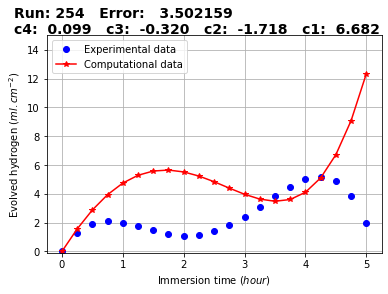

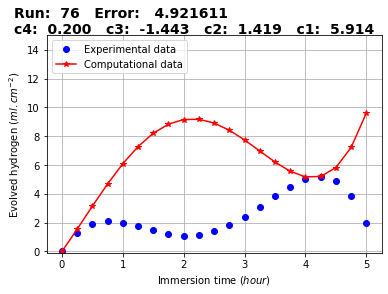

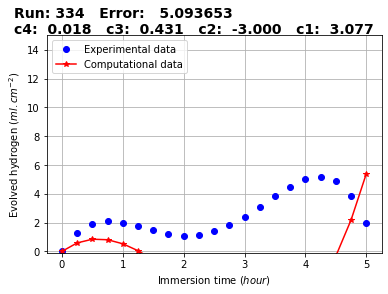

     Run        c4        c3        c2        c1     Error
172  254  0.098999 -0.319938 -1.718147  6.681973  3.502159
374   76  0.200002 -1.443464  1.418639  5.914239  4.921611
261  334  0.017820  0.431014 -2.999926  3.076545  5.093653
177  259  0.192626 -0.964103 -1.064924  8.561809  5.344120
294  364  0.303723 -1.917140  2.137436  4.073736  6.351661
387   88  0.266809 -1.939923  2.984849  4.046632  6.556045
212  290  0.076269 -0.388415 -1.217481  8.561460  6.652629
361   64  0.238904 -2.067035  3.341969  5.852873  6.682688
218  296  0.033101  0.089651 -2.424915  8.776387  6.798362
363   66  0.341595 -2.616007  3.397339  7.459837  6.967702


<Figure size 432x288 with 0 Axes>

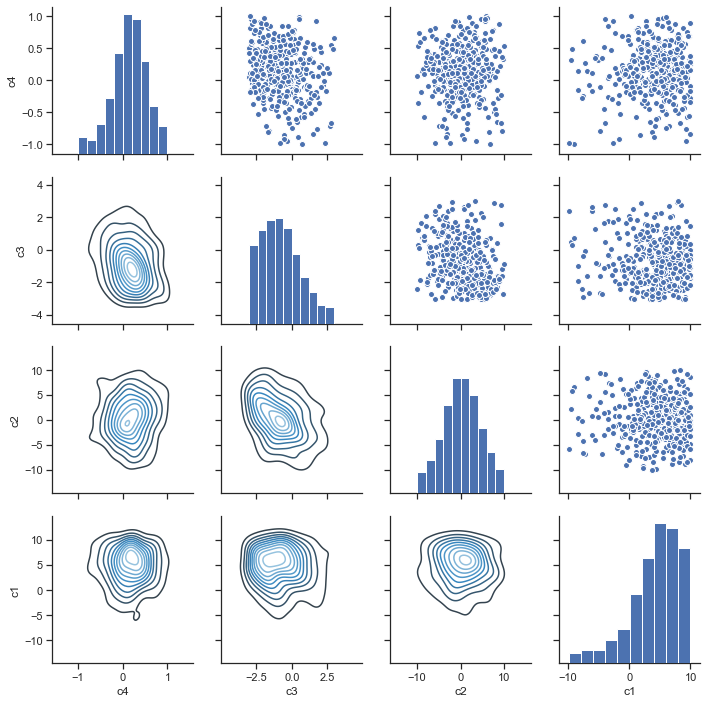

In [15]:
plotResults()

### Tune the parameters and start the second round

Cool. Although even the best simulation is not close enough to a good approximation, this initial parameter estimation has given us some good clues about a narrower range of search. So by averaging the values of best simulations, we can refine the search domain and re-run the optimization. Let's do that.

In [16]:
ranges = {
    'c4': (-1, 0),
    'c3': (0, 3),
    'c2': (-10, -5),
    'c1': (5, 10)
}

runOptimization()

100%|██████████████████████████████████████████████████| 400/400 [01:17<00:00,  5.16it/s, best loss: 1.492772377602438]


And after that, we run the post-processor to see the performance of parameter estimation.

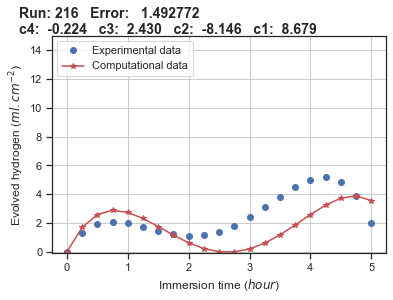

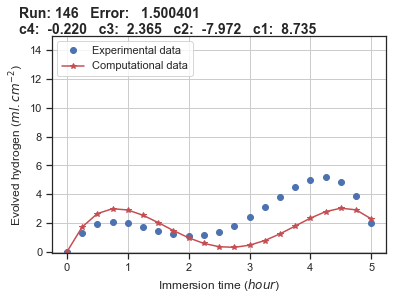

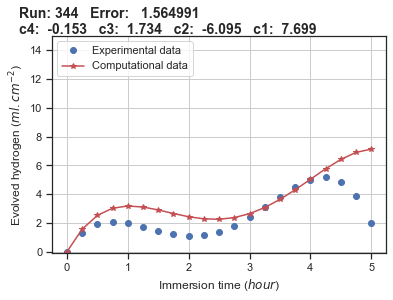

     Run        c4        c3        c2        c1     Error
130  216 -0.223946  2.430324 -8.146227  8.678986  1.492772
52   146 -0.220309  2.364923 -7.972308  8.735208  1.500401
272  344 -0.153161  1.733908 -6.095062  7.699329  1.564991
170  252 -0.264085  2.838870 -8.981868  8.789337  2.239223
229  305 -0.171474  2.004546 -7.204750  7.933706  2.327870
271  343 -0.266565  2.374784 -6.954638  8.609030  2.351933
306  375 -0.255733  2.303097 -6.841586  7.605518  2.387730
155  239 -0.268240  2.468317 -7.726330  9.541837  2.555017
73   165 -0.286704  2.513141 -7.125959  8.558126  2.557654
157  240 -0.152064  2.012756 -7.715537  9.590707  2.756607


<Figure size 432x288 with 0 Axes>

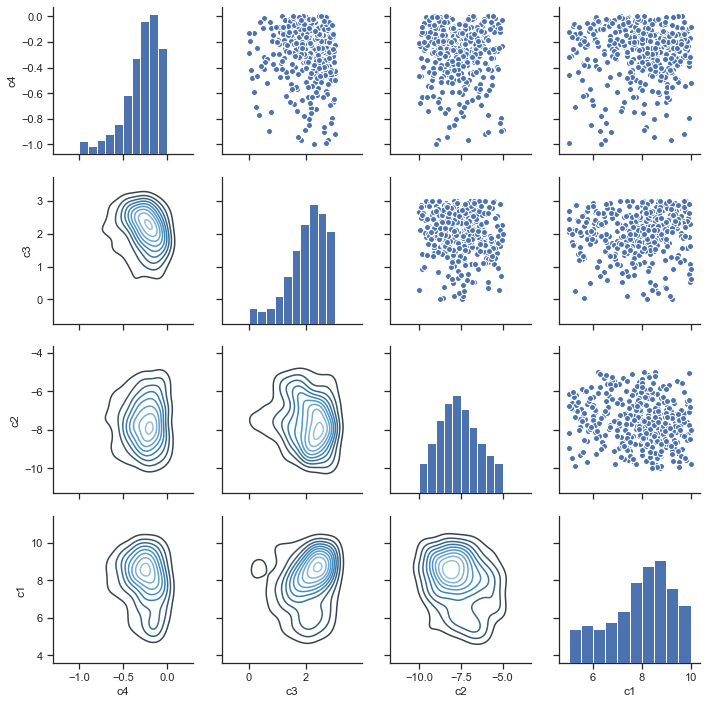

In [17]:
plotResults()

Ummm. Much better results. Now the curve generated by the external simulation program is closer to the behavior of experimental data. From the pair-plots, it can be seen how the Bayesian algorithm is choosing points closer to the proper values.

### Second tuning of the optimization parameters to get the final results

Now for the second time, we can refine the domain by paying attention to the pair-plot and averaging the parameters estimated for the runs with the lowest error. After that, we run the post-processor again.

In [18]:
ranges = {
    'c4': (-0.5, 0),
    'c3': (2, 3),
    'c2': (-8, -5),
    'c1': (5, 8)
}

runOptimization()

100%|█████████████████████████████████████████████████| 400/400 [01:18<00:00,  5.07it/s, best loss: 1.0306047672155054]


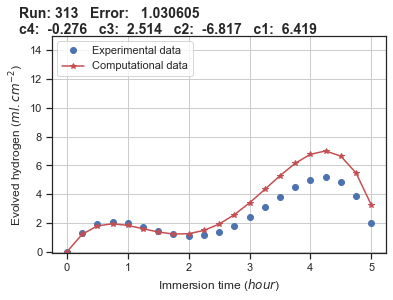

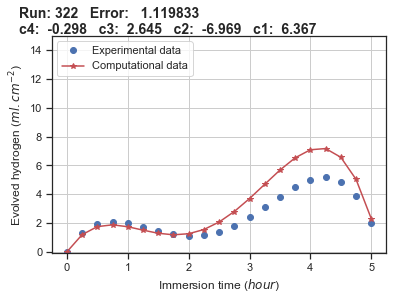

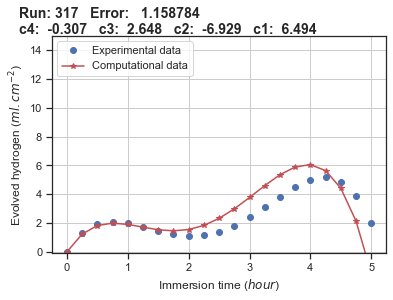

     Run        c4        c3        c2        c1     Error
238  313 -0.276189  2.513701 -6.817031  6.418895  1.030605
248  322 -0.297552  2.645382 -6.969192  6.366573  1.119833
242  317 -0.306870  2.648383 -6.928581  6.494311  1.158784
176  258 -0.325533  2.724062 -6.767258  5.984642  1.485137
269  341 -0.304093  2.601777 -6.669277  6.354247  1.505906
26   122 -0.289361  2.561650 -6.917908  7.071863  1.579234
82   173 -0.292490  2.657723 -7.135060  6.689571  1.689762
323  390 -0.243655  2.370015 -6.692261  6.068535  1.695723
177  259 -0.311294  2.664625 -6.736141  5.292649  1.703063
24   120 -0.290713  2.538631 -6.794355  7.085618  1.807692


<Figure size 432x288 with 0 Axes>

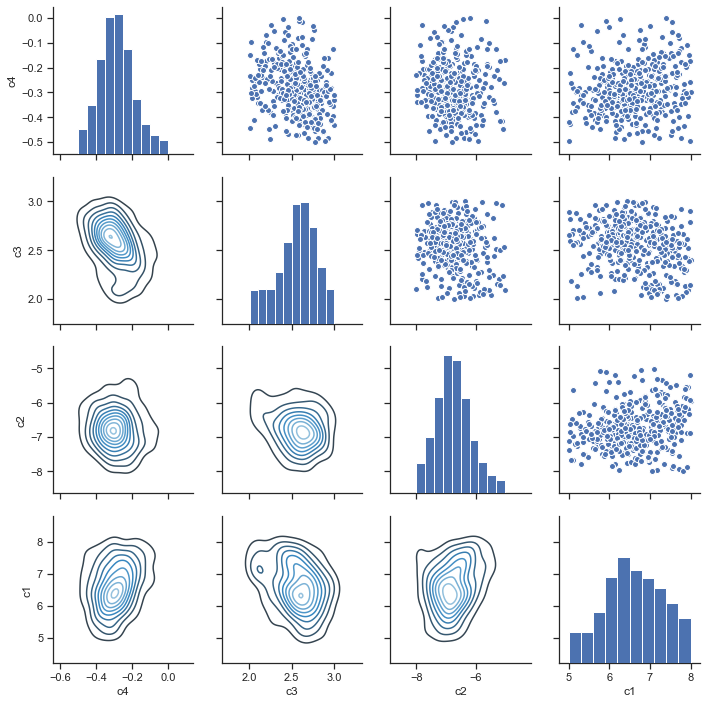

In [19]:
plotResults()

This time the results are so close to the experimental data and the errors are relatively low. So the averaging the top 3 run (or just obtaining the first run) leads to the final values of parameters we were seeking for. Lets have a look how accurate these values are. The estimated parameters are:

$$ c_4 = -0.27, c_3 = 2.51, c_2 = -6.81, c_1 = 6.41 $$

And as can we approximated the function by a simple interpolation technique, the correct values are:

$$ c_4 = -0.25, c_3 = 2.35, c_2 = -6.75, c_1 = 6.65 $$

Very nice, these values are close enough for computational engineering projects. If you need more accurate parameters for your specific application, you can continue the process by narrowing the search domain range and re-running the optimization algorithm.

## Summary 

So, this is the end of the crash course. In this tiny learning module, you learned the basics of the following topics:

* Necessity of parameter estimation for computational models 
* What an inverse problem is and how it is related to mathematical optimization
* The typical workflow of an optimization problem in general and parameter estimation in specific
* How a parameter estimation procedure is implemented and how it should be fine-tuned